*The following notebook walks through the beginning stages of my development of a model for predicting the outcomes of an MLB playoff bracket. While this project is likely slightly different from many other writing samples you receive, baseball sabermetrics -- the systematic study of baseball statistics -- has been a longstanding passion of mine, and I believe this notebook highlights many of the very interesting statistical problems encountered when attempting to build a predictive model. I believe there are several aspects of playoff baseball modelling that make it a unique challenge for an aspiring forecaster as opposed to a typical prediction problem. The two most interesting problems at play here are that the structure of the prediction problem makes simpler techniques like linear regression not a good choice to tackle this problem and that the process of model evaluation in the context of building a playoff model is vacuous and complex -- I struggle with both of these issues over the course of this notebook. This notebook attempts to develop a simple playoff model based on team regular season win-loss record and trains on many years of historical playoff data.*

This notebook walks through the process of attempting to build as advanced an MLB playoff predictive model as possible using only team statistics. Though this approach is likely inferior to a more sophisticated model built on the microfoundations of individual player data, it will hopefully both serve as a strong baseline model to compare future models to and be a nice way to practice iterating on a very simple baseline playoff model to add complexity and hopefully improve model performance. 

In [474]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from pybaseball import standings, team_results
from pybaseball import team_batting
from pybaseball import team_pitching
from pybaseball import retrosheet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

abspath = os.path.abspath(os.getcwd())
finpath = Path(abspath).resolve().parent.parent

Our first task is to build a database of playoff bracket results from 1970 to the present for the purposes of model evaluation. To accomplish this, we utilize the pybaseball library's retrosheet API, which fetches data from the retrosheet website's historical playoff game logs. Note that we do not include the more recent wild card games, which were introduced in 2012, because we worry that the single game nature of these games, as opposed to the longer 5 and 7 game series we see otherwise, would skew our results. Therefore, we just consider the winner of the wild card games as belonging to the playoff bracket. 

In [475]:
world_series = retrosheet.world_series_logs()
world_series["year"] = [int(''.join(list(str(x))[:4])) for x in world_series["date"]]
ws_modern = world_series[world_series["year"] >= 1970]
ws_modern = ws_modern[["year", "home_team", "visiting_team", "visiting_team_game_num", "visiting_score", "home_score"]]
winners = ws_modern.loc[ws_modern.groupby("year")["visiting_team_game_num"].idxmax()] 
winners["Won WS"] = np.where(winners["home_score"] > winners["visiting_score"], winners["home_team"], winners["visiting_team"])
winners["Lost in WS"] = np.where(winners["home_score"] > winners["visiting_score"], winners["visiting_team"], winners["home_team"])
winners["Won WS"] = winners["Won WS"].apply(lambda x : [x])
winners["Lost in WS"] = winners["Lost in WS"].apply(lambda x : [x])
winners = winners[["year", "Won WS", "Lost in WS"]]
winners = winners.set_index("year")
playoff_bracket = winners.to_dict('index')


In [476]:
lcs = retrosheet.lcs_logs()
lcs["year"] = [int(''.join(list(str(x))[:4])) for x in lcs["date"]]
lcs_modern = lcs[lcs["year"] >= 1970]
lcs_modern = lcs_modern[["year", "home_team", "visiting_team", "visiting_team_game_num",
                         "visiting_score", "home_score", "visiting_team_league"]]
winners = lcs_modern.loc[lcs_modern.groupby(["year", "visiting_team_league"])["visiting_team_game_num"].idxmax()] 
winners["Lost in LCS"] = np.where(winners["home_score"] > winners["visiting_score"], winners["visiting_team"], winners["home_team"])
winners = winners[["year", "Lost in LCS", "visiting_team_league"]]

for x in winners.itertuples():
    if "Lost in LCS" not in playoff_bracket[x[1]]:
        playoff_bracket[x[1]]["Lost in LCS"] = [x[-2]]
    else:
        playoff_bracket[x[1]]["Lost in LCS"].append(x[-2])

In [477]:
ds = retrosheet.division_series_logs()
ds["year"] = [int(''.join(list(str(x))[:4])) for x in ds["date"]]
ds_modern = ds[ds["year"] >= 1970]
ds_modern['teams'] = ds_modern[['home_team', 'visiting_team']].apply(lambda x: tuple(sorted(','.join(x).split(','))), axis=1)
ds_modern = ds_modern[["year", "home_team", "visiting_team", "visiting_team_game_num",
                         "visiting_score", "home_score", "visiting_team_league", "teams"]]
winners = ds_modern.loc[ds_modern.groupby(["year", "visiting_team_league", "teams"])["visiting_team_game_num"].idxmax()]
winners["Lost in DS"] = np.where(winners["home_score"] > winners["visiting_score"], winners["visiting_team"], winners["home_team"])
winners = winners[["year", "Lost in DS", "visiting_team_league"]]

for x in winners.itertuples():
    if "Lost in DS" not in playoff_bracket[x[1]]:
        playoff_bracket[x[1]]["Lost in DS"] = [x[-2]]
    else:
        playoff_bracket[x[1]]["Lost in DS"].append(x[-2])


In [479]:
def get_playoff_teams(playoff_bracket):
    playoff_teams = {}
    for year in playoff_bracket:
        teams = []
        for x in playoff_bracket[year]:
            teams += playoff_bracket[year][x]
        playoff_teams[year] = teams
    return playoff_teams

In [480]:
playoff_teams = get_playoff_teams(playoff_bracket)

Next, to build our predictive model, we want to collect some data about the teams in each playoff bracket from 1970 to the present. Because this is going to be our first iteration of our playoff model -- a kind of baseline for the rest of our analysis -- we will only be collecting each team's winning percentage as of now. In the future, we would hope to add more features for each team to make playoff predictions on. These features could include factors like run differential, winning percentage against winning teams, the stats of the team's two best starting pitchers, and more. We will then store all this data in a dictionary so that we can run our models. We utilize a previously written function in our utils python file to make it easier to scrape the standings and store the data in the structure we need. 

In [481]:
import utils

In [482]:
utils.write_simple_standings_to_df(1970, 2019, str(finpath) + '/sabermetrics_playground/storage/team_data.csv')

In [483]:
team_data = pd.read_csv(str(finpath) + '/sabermetrics_playground/storage/team_data.csv')

In [484]:
team_data['index'] = list(zip(team_data["Year"], team_data["Tm"]))
team_data = team_data[["index", "W-L%"]]
team_data = team_data.set_index('index')
team_dict = team_data.to_dict()["W-L%"]

In [485]:
import json

In [486]:
with open(str(finpath) + '/sabermetrics_playground/storage/rs_team_mapping.json', 'r') as infile:
    symbol_dict = json.load(infile)

The final piece of infrastructure we need to set up before we can iterate through interesting models and score them relative to historical results is a process by which our theoretical model will make predictions. The nature of prediction in this problem is unique and meaningfully different from other prediction problems where we could potentially use conventional regression techniques. 

If we were interested in predicting only World Series outcomes between two teams, for example, we could imagine that, taking two teams' winning percentages, or perhaps the difference between their winning percentages, as an input, we could simply look at historical outcomes of World Series games and run linear regression to derive a relationship between the difference in two teams' winning percentages and each of their chances to win the World Series. However, the problem we wish to tackle is significantly more complex. Our aim is to produce a model that gives the odds each team in a playoff bracket has to achieve one of potentially many different outcomes, from a World Series to a first round exit. Thus, we have a problem where we are interested in generating, and evaluating, multiple outputs, from multiple inputs. In the case where we are generating a model from only team winning percentages, in a year in which 8 teams make the playoffs, we need to construct a model that takes in 8 inputs -- team winning percentages -- and 32 outputs -- probabilities for each team that they achieve each of four potential outcomes. 

It thus becomes clear that simple linear regression is not well equipped to solve this problem. I thought of two potential solutions to this problem, each of which I will briefly outline below:

1. The optimization approach

    The first approach we could take is to write an enormous regression formula that we could then theoretically optimize to minimize the mean squared error. Despite the complexity of the problem at hand, this is still theoretically possible. If we define each team's odds to defeat another team in a series with the formula

    $\text{Odds of winning series} = 0.5 + \beta * \text{Team winning percentage - Opponent winning percentage}$

    Then we can still potentially recover a theoretically convex overall function that takes 8 team winning percentages as an input and gives 32 outputs. As a (relatively) simple example, let's look at the formula under this construction that would give a team's odds of losing in the championship game (the second round of the playoffs):

    $\text{Odds of losing in LCS} = \text{Odds of winning first round series} * \sum{opponents}\text{[Odds of winning series vs potential opponent]} * \text{[Odds of potential opponent winning their first round series]}$

    Even this simple example is quite confusing. It is theoretically possible to compute each team's first round winning odds, then using those odds to compute each team's second round winning odds, and so forth until the odds computed for a given beta parameter are found for all teams and all potential outcomes. However, this approach is extremely computationally expensive and confusing, especially because this would then need to combined with the MSE formula to find an optimal beta. Additionally, is MSE even the metric we necessarily care about optimizing for? How do we determine the correct evaluation metric to use for a problem such as playoff prediction? More on this later.

    Additionally, there is an issue here in that there are a differing number of games in various playoff rounds in the MLB. In the division series, teams play a best-of-5, while in the LCS and World Series, teams play a best-of-7. This means that the same two teams playing in the division series as opposed to the league championship series would have different odds of winning each series because playing more games, as in the LCS, would give stronger odds of advancing to the better team.

    Overall, while it seems theoretically possible to perform an extremely complicated convex optimization process to recover a relationshi between winning percentage and team playoff outcomes to generate a playoff model, there are a number of computational and theoretical hurdles that make this pursuit not ideal, which brings us to...

2. Monte Carlo simulation

    A far easier and more flexible solution is to simulate each individual game according to a formula that takes in information about each team and outputs a win probability for that game for each team. These games can then be aggregate to simulate series, which can be aggregated to simulate entire playoff brackets. We then utilize Monte Carlo simulations to run 10000 simulations of each year's playoffs and log the number of times each team attains a particular outcome (wins World Series, loses World Series, loses in first round, etc). Finally, we compare the proportion each team attains each outcome to what actually happened in the real historical playoffs and, according to a cost function that will be discussed later (and it will be discussed extensively as it's an extremely interesting problem), a model's accuracy will then be evaluated. At first, we will attempt to use the simple winning percentage formula described above to uncover a beta coefficient that best describes the relationship between winning percentage and the distribution of playoff outcomes. To execute this strategy, we needed to create tournament class that would perform all the functionality I described above in simulating a playoff bracket, and I then coded up functions that would run the Monte Carlo simulations and score each playoff model, each with a different beta coefficient, to find the "best" beta coefficient for a given model. Here, we use the following evaluation model:

    Error = $\sum_{teams}\sum_{outcomes}\text{(Distance from Outcome)}*|\text{Actual Outcome - Projected Outcome}|$

    Here, the actual and projected outcomes are represented by arrays of length equal to the number of possible outcomes a team can have in the playoffs (World Series win, World Series Loss, ALCS loss, etc.). The actual outcomes array is an array of zeroes and a single value of one, which corresponds to the team's ultimate bracket placement. For example, in the 2021 playoff format, since the Braves avoided the Wild Card round, their array would be represented as [Lost in NLDS, Lost in NLCS, Lost in WS, Won WS] = [0,0,0,1]. The projected outcomes array is in the same format as the actual outcomes array, but gives the percentage of time a team ended up with the placement corresponding to the array index as an input for each index. For example, the Braves' 2021 projected outcomes array might have looked something like [45, 22, 9, 4]. 

    The distance from an outcome is defined as the number of 'steps' away from the actual outcome the projected outcome was. For example, if the Tigers were projected to win the World Series but actually lost in the ALCS, the distance between these outcomes would be 2, but if they lost in the World Series, the distance would be 1. 

    To compute the total error (our evaluation of 'how good' the model is), we sum over the error we compute for every single year of the playoffs. Our models make predictions for each year of the playoffs on record -- every year after 1970 except for the strike shortened 1994 season -- and those predictions are compared to the actual results, and the sum of those error is our total error. 

    Luckily, the Monte Carlo simulations are extremely fast -- simulating 10000 playoff brackets takes just over 13 seconds, meaning that we can use grid search to find the model that performs best according to the evaluation function. The code for all these operations is provided below. 

In [487]:
class Tournament():
    '''
    '''
    def __init__(self, teams_lst, rounds={"DS" : 5, "LCS" : 7, "WS" : 7}):
        self.teams_lst = teams_lst
        self.placing_dict = {}
        self.rounds = rounds

    def simulate_series(self, teams, function, year, num_games):
        team1_wins = 0
        team2_wins = 0
        while (team1_wins < num_games / 2) and (team2_wins < num_games / 2):
            winner = function(*teams, year)
            if winner == teams[0]:
                team1_wins += 1
            else:
                team2_wins += 1
        if team1_wins > team2_wins:
            return teams[0], teams[1]
        else:
            return teams[1], teams[0]

    def simulate_round(self, teams_lst, function, year, round):
        winners = []
        losers = []
        teams = []
        for team in teams_lst:
            teams.append(team)
            if len(teams) == 2:
                winner, loser = self.simulate_series(teams, function, year, self.rounds[round])
                winners.append(winner)
                losers.append(loser)
                teams = []
        return winners, losers

    def simulate_playoffs(self, function, year):
        if len(self.teams_lst) == 8:
            round = 'DS'
        elif len(self.teams_lst) == 4:
            round = 'LCS'
        elif len(self.teams_lst) == 2:
            round = 'WS'
        teams_remaining = self.teams_lst
        while len(teams_remaining) > 1:
            winners, losers = self.simulate_round(teams_remaining, function, year, round)
            self.placing_dict["Lost in " + round] = losers
            if len(teams_remaining) == 2:
                self.placing_dict["Won WS"] = winners
            teams_remaining = winners
            if len(teams_remaining) == 8:
                round = 'DS'
            elif len(teams_remaining) == 4:
                round = 'LCS'
            elif len(teams_remaining) == 2:
                round = 'WS'

In [488]:
import random

In [489]:
def simple_win_percent_model(team1, team2, year):
    p1 = .5 + team_dict[(year, symbol_dict[team1])] - team_dict[(year, symbol_dict[team2])]
    rand_num = random.random()
    if rand_num > p1:
        return team2
    else:
        return team1

In [490]:
def create_placing_dict(master_dict, year, playoff_teams):
    master_dict[year] = {}
    for team in playoff_teams[year]:
        if len(playoff_teams[year]) == 8:
            master_dict[year][team] = {"Lost in DS" : 0, "Lost in LCS" : 0,
                                         "Lost in WS" : 0, "Won WS" : 0}
        elif len(playoff_teams[year]) == 4:
            master_dict[year][team] = {"Lost in LCS" : 0, "Lost in WS" : 0,
                                         "Won WS" : 0}
    return master_dict

def update_placing_dict(master_dict, placing_dict, year, trials):
    for placing, teams in placing_dict.items():
        for team in teams:
            master_dict[year][team][placing] += 1 / trials
    return master_dict

In [586]:
def playoff_sim(trials, func, year_start=1970, year_end=2019):
    master_dict = {}
    count = 0
    for _ in range(trials):
        for year in range(year_start, year_end + 1):
            if year != 1994:
                teams_lst = playoff_teams[year]
                bracket = Tournament(teams_lst)
                bracket.simulate_playoffs(func, year)
                if count == 0:
                    master_dict = create_placing_dict(master_dict, year, playoff_teams)
                master_dict = update_placing_dict(master_dict, bracket.placing_dict, year, trials)
        if count == 0:
            count = 1
    return master_dict

def score_simulation(master_dict, playoff_bracket, year_start=1970, year_end=2019, cost=1):
    scores = []
    outcomes_dict = {"Lost in DS" : 1, "Lost in LCS" : 2, "Lost in WS" : 3, "Won WS" : 4}
    results_dict = {}
    for year in range(year_start, year_end + 1):
        if year != 1994:
            score = 0
            results_dict = create_placing_dict(results_dict, year, playoff_teams)
            results_dict = update_placing_dict(results_dict, playoff_bracket[year], year, 1)
            for team in master_dict[year]:
                projections = master_dict[year][team]
                results = results_dict[year][team]
                outcome = list(results.keys())[list(results.values()).index(1)]
                for key in projections:
                    multiplier = np.abs(outcomes_dict[key] - outcomes_dict[outcome])
                    score += multiplier * (projections[key] ** cost)
            scores.append(score)
    return np.array(scores), np.sum(np.array(scores))

Let's begin simply by assuming a beta coefficient of 1, meaning that a better team's winning percentage in a game will be equal to 0.5 plus the difference in the two teams' winning percentages. 

In [530]:
projections_dict = playoff_sim(10000, simple_win_percent_model)
yearly_errors, total_error = score_simulation(projections_dict, playoff_bracket)

In [545]:
print("Mean of yearly errors:", yearly_errors.mean())
print("Standard Deviation of yearly errors:", yearly_errors.std())
print("Total error score:", total_error)

Mean of yearly errors: 6.229555102040543
Standard Deviation of yearly errors: 2.614330396266118
Total error score: 305.2481999999866


Interesting. However, we can't contextualize how well our model performed unless we have a baseline model to compare it against. As a baseline, let's use the simplest model I could think of: in every round, the better team will always advance. Note that this is almost equivalent to setting an extremely high beta coefficient. 

In [579]:
def better_team_wins_model(team1, team2, year):
    team1_win_percent = team_dict[(year, symbol_dict[team1])] 
    team2_win_percent = team_dict[(year, symbol_dict[team2])]
    if team1_win_percent >= team2_win_percent:
        return team1
    else:
        return team2

In [568]:
baseline_projections_dict = playoff_sim(10000, better_team_wins_model)
baseline_yearly_errors, baseline_total_error = score_simulation(baseline_projections_dict, playoff_bracket)

In [569]:
print("Mean of yearly errors:", baseline_yearly_errors.mean())
print("Standard Deviation of yearly errors:", baseline_yearly_errors.std())
print("Total error score:", baseline_total_error)

Mean of yearly errors: 5.999999999999438
Standard Deviation of yearly errors: 2.770102775666214
Total error score: 293.99999999997243


Well that's not very good. It appears that our model fails to outperform the simplest model I could think of. Let's try the grid search I mentioned above and plot the total error scores for each beta coefficient, where the x axis represents candidate beta coefficient values and the y axis represents error scores:

In [560]:
def modified_simple_win_percent_model(team1, team2, year):
    p1 = .5 + coef * (team_dict[(year, symbol_dict[team1])] - team_dict[(year, symbol_dict[team2])])
    rand_num = random.random()
    if rand_num > p1:
        return team2
    else:
        return team1

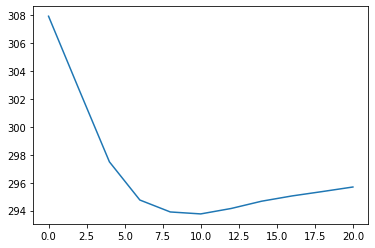

In [578]:
possible_coefs = np.linspace(0, 20, 11)

errors = []
for coef in possible_coefs:
    projections_dict = playoff_sim(10000, modified_simple_win_percent_model)
    yearly_errors, total_error = score_simulation(projections_dict, playoff_bracket)
    errors.append(total_error)

plt.plot(possible_coefs, errors)

Hmm. It appears that no beta coefficient outperforms the baseline model. What to do? 

It was at this point that I realized what my issue was: my evaluation function. Depending on the evaluation function I use, certain distributions of predicted outcomes for team placements are rewarded more or less. Using the evaluation function I had been using up until this point, it is actually very natural that my model would never be able to outperform my simple baseline model. This is because my model overly rewards narrow distributions of predicted outcomes over wider, more conservative distributions of predictions. The baseline model can be seen as giving the most extreme narrow distribution of outcomes. The way the baseline model works is that it makes the best possible predictions if one had to choose one World Series winner, one World series loser, and so on because if one knew only team winning percentages and had to predict a World Series winner, it would be natural to pick the team with the highest winning percentage. We can modify how much the evaluation function punishes overconfidence in predictions by adding a cost exponent:

Error = $\sum_{teams}\sum_{outcomes}\text{(Distance from Outcome)}*|\text{Actual Outcome - Projected Outcome}|^{\text{cost}}$

Varying this exponent will vary how much the evaluation function punishes overconfidence in a given model's predictions. Higher values for the cost will favor conservative playoff predictions. To see how this works, look below at what happens when we set a cost parameter of 2:

In [587]:
baseline_projections_dict = playoff_sim(1, better_team_wins_model)
baseline_yearly_errors, baseline_total_error = score_simulation(baseline_projections_dict, playoff_bracket, cost=2)

In [588]:
print("Mean of yearly errors:", baseline_yearly_errors.mean())
print("Standard Deviation of yearly errors:", baseline_yearly_errors.std())
print("Total error score:", baseline_total_error)

Mean of yearly errors: 6.0
Standard Deviation of yearly errors: 2.770102775666474
Total error score: 294.0


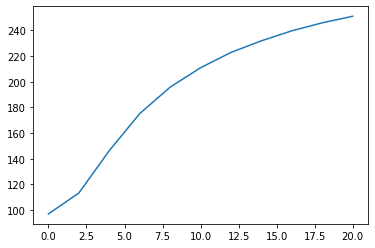

In [592]:
possible_coefs = np.linspace(0, 20, 11)

errors = []
for coef in possible_coefs:
    projections_dict = playoff_sim(10000, modified_simple_win_percent_model)
    yearly_errors, total_error = score_simulation(projections_dict, playoff_bracket, cost=2)
    errors.append(total_error)

plt.plot(possible_coefs, errors)

We see here that using this new evaluation function, many of our model's candidate beta values greatly outperform the baseline model in terms of total error. 

We have solved the issue of the baseline model being rewarded too much by our evaluation functions. However, a much deeper and more complex problem becomes clear here: how do we really compare the performance of two playoff models and evaluate which one is better when it seems that this depends on our choices in the evaluation function, and how do we decide what the best evaluation function to use is? This problem seems completely intractable: one can justify using certain evaluation functions that seem "reasonable," but this is still a massive issue for evaluating the models that we want to build. 

The solution to this issue will be expounded upon in a further notebook and involves a very cool method developed by Bill Deere at Fangraphs. This method applies a game theoretic methodology whereby two models are compared by directly competing with each other and attempting to exploit the other model by "betting" against the odds the other model comes up with. The process is a little involved, but I believe it is a very promising way to sidestep the issue of evaluation function selection and allow us to truly get a good read on model performance.

This notebook has set up a lot of the infrastructure that we are interested in for developing and refining a playoff model for baseball. Through this work, I also discovered many of the interesting problems in developing such a model, from selection of a model generation methodology to the very interesting problems associated with model evaluation. 